In [1]:
import os
import pandas as pd
from PIL import Image

directory_of_eval_images = os.path.abspath(
    "/home/fidelius/eval_data/eval_images/"
)  # download from gs://bonprix-images/250324_quality_classifier_dataset (paws project)
directory_of_mask_images = os.path.abspath(
    "/home/fidelius/eval_data/eval_masks/"
)  # download from gs://bonprix-images/250324_quality_classifier_dataset (paws project)

labels_df = pd.read_csv(os.path.join(directory_of_eval_images, "labels.csv"))

labels_df["name"] = labels_df["image_path"].apply(lambda x: os.path.basename(x))

labels_df["image_path"] = labels_df["name"].apply(
    lambda x: os.path.join(directory_of_eval_images, x)
)

labels_df["mask_path"] = labels_df["name"].apply(
    lambda x: os.path.join(directory_of_mask_images, x.replace(".jpg", ".png"))
)

labels_df.head()

,image_path,label,name,mask_path
0,/home/fidelius/eval_data/eval_images/579240700...,real_photo,5792407003_911302_24102620.jpg,/home/fidelius/eval_data/eval_masks/5792407003...
1,/home/fidelius/eval_data/eval_images/513240200...,real_photo,5132402001_909758_24007277.jpg,/home/fidelius/eval_data/eval_masks/5132402001...
2,/home/fidelius/eval_data/eval_images/644240700...,real_photo,6442407005_926192_24102052.jpg,/home/fidelius/eval_data/eval_masks/6442407005...
3,/home/fidelius/eval_data/eval_images/522240320...,real_photo,5222403201-7132403000_903105-912277_24003170.jpg,/home/fidelius/eval_data/eval_masks/5222403201...
4,/home/fidelius/eval_data/eval_images/636230300...,real_photo,6362303000-5222403202_927905-951926_24005926.jpg,/home/fidelius/eval_data/eval_masks/6362303000...


In [2]:
from pixaris.metrics.luminescence import LuminescenceComparisonByMaskMetric

metric = LuminescenceComparisonByMaskMetric([])

x = labels_df["name"].loc[0]
print(x)
image = Image.open(os.path.join(directory_of_eval_images, x))
mask = Image.open(os.path.join(directory_of_mask_images, x.replace(".jpg", ".png")))
metric._luminescence_difference(image, mask)

5792407003_911302_24102620.jpg


np.float64(0.9997824162002562)

In [3]:
labels_df["luminescence"] = labels_df["name"].apply(
    lambda x: metric._luminescence_difference(
        Image.open(os.path.join(directory_of_eval_images, x)),
        Image.open(os.path.join(directory_of_mask_images, x.replace(".jpg", ".png"))),
    )
)
labels_df.head()

,image_path,label,name,mask_path,luminescence
0,/home/fidelius/eval_data/eval_images/579240700...,real_photo,5792407003_911302_24102620.jpg,/home/fidelius/eval_data/eval_masks/5792407003...,0.999782
1,/home/fidelius/eval_data/eval_images/513240200...,real_photo,5132402001_909758_24007277.jpg,/home/fidelius/eval_data/eval_masks/5132402001...,0.999826
2,/home/fidelius/eval_data/eval_images/644240700...,real_photo,6442407005_926192_24102052.jpg,/home/fidelius/eval_data/eval_masks/6442407005...,0.999772
3,/home/fidelius/eval_data/eval_images/522240320...,real_photo,5222403201-7132403000_903105-912277_24003170.jpg,/home/fidelius/eval_data/eval_masks/5222403201...,0.999745
4,/home/fidelius/eval_data/eval_images/636230300...,real_photo,6362303000-5222403202_927905-951926_24005926.jpg,/home/fidelius/eval_data/eval_masks/6362303000...,0.999817


In [4]:
# Beschreibende Statistik gruppiert nach 'label'
grouped_describe = labels_df.groupby("label").describe()

# Ausgabe der Ergebnisse
grouped_describe

luminescence                                          \
                        count      mean       std       min       25%   
label                                                                   
batch_generation         38.0  0.998768  0.000774  0.997410  0.998108   
hq_generation            10.0  0.999558  0.000351  0.999118  0.999229   
real_photo               28.0  0.999626  0.000405  0.998114  0.999538   

                                                
                       50%       75%       max  
label                                           
batch_generation  0.998792  0.999529  0.999875  
hq_generation     0.999579  0.999904  0.999951  
real_photo        0.999777  0.999838  0.999965

In [5]:
# Konfusionsmatrix ohne sklearn
import pandas as pd
import matplotlib.pyplot as plt

for label in ["batch_generation", "hq_generation"]:
    results_df_batch = labels_df.copy()
    results_df_batch = results_df_batch[
        results_df_batch["label"].isin([label, "real_photo"])
    ]

    # Wahre Labels und vorhergesagte Labels extrahieren
    true_labels = results_df_batch["label"].apply(
        lambda x: "artificial" if x == label else "real"
    )
    predicted_labels = results_df_batch["luminescence"].apply(
        lambda x: "artificial" if x < 0.8 else "real"
    )

    # Kategorien definieren
    categories = ["artificial", "real"]
    true_labels_list = true_labels.unique()
    true_labels_list.sort()

    # Konfusionsmatrix initialisieren
    confusion_matrix = pd.DataFrame(0, index=categories, columns=true_labels_list)

    # Matrix füllen
    for true, pred in zip(true_labels, predicted_labels):
        confusion_matrix.loc[true, pred] += 1

    # Konfusionsmatrix anzeigen
    print("*** ", label, " ***")
    print(confusion_matrix)

***  batch_generation  ***
            artificial  real
artificial           0    38
real                 0    28
***  hq_generation  ***
            artificial  real
artificial           0    10
real                 0    28


Text(0.5, 1.0, 'Violinplot of artificial score by label')

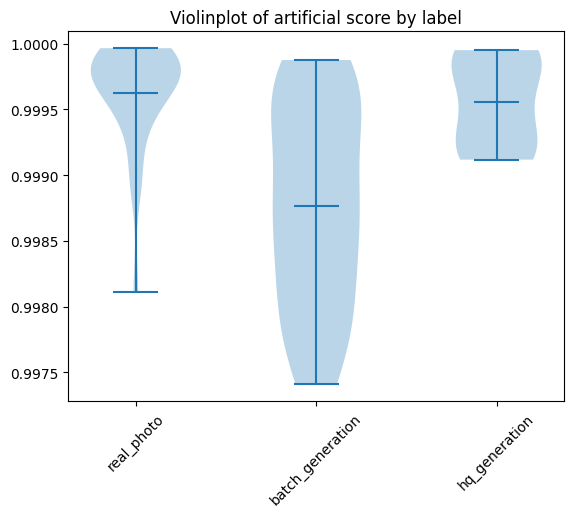

In [6]:
# violinplot grouped by label

labels = labels_df["label"].unique()
data = [labels_df[labels_df["label"] == label]["luminescence"] for label in labels]

plt.violinplot(data, showmeans=True)
plt.xticks(ticks=range(1, len(labels) + 1), labels=labels, rotation=45)
plt.title("Violinplot of artificial score by label")